# Best Neighborhood in Pittsburgh – Final Report

This notebook presents the final combined analysis for our Big Idea final project.

Our goal is to answer the question:

> **Which neighborhood in Pittsburgh is the "best" according to our data-driven metric?**

We focus on everyday, lived-experience aspects of neighborhoods that are:
- **Clean and convenient** to use public trash containers,
- **Not too painful to park in**, and
- **Comfortable and interesting to walk through**, especially in terms of city steps.

To do this, our team (Procrastinateam) defined three sub-metrics:

1. **Smart Trash Score (`trash_score`)**
   Density of smart trash containers per neighborhood, representing cleanliness and convenience.

2. **Parking Score (`parking_score`)**
   A reverse of a "parking pain" index based on the number of parking points and their hourly costs.
   Higher values mean **less parking pain** (easier and/or cheaper parking).

3. **City Steps Score (`compact_stair_score`)**
   A measure of how rich and compact the city steps network is in each neighborhood, capturing a vertical walkability dimension.

In this final notebook, we:
- Load each processed metric,
- Merge them by neighborhood,
- Combine them into a single **Bestness Score**,
- Rank all neighborhoods, and
- Visualize the results using both bar charts and a choropleth map.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

try:
    import geopandas as gpd
    GEOPANDAS_AVAILABLE = True
except ImportError:
    GEOPANDAS_AVAILABLE = False
    print("GeoPandas is not available in this environment. Map plots will be skipped.")

## 1. Loading processed metric tables

Each team member produced a cleaned and aggregated CSV for their sub-metric:

- `smart_trash_metric_by_hood.csv` with `trash_score`
- `parking_scores.csv` with `parking_score`
- `steps_scores.csv` with `compact_stair_score` (among other columns)

All of these files live in `data/processed/`.

We now load these tables and select only the columns we need for the combined metric.

In [7]:
# Load processed sub-metric tables
trash = pd.read_csv("../data/processed/smart_trash_metric_by_hood.csv")
parking = pd.read_csv("../data/processed/parking_scores.csv")
steps = pd.read_csv("../data/processed/steps_scores.csv")

print("Trash metric columns:", list(trash.columns))
print("Parking metric columns:", list(parking.columns))
print("Steps metric columns:", list(steps.columns))

trash.head()

Trash metric columns: ['hood', 'area_sqmiles', 'trash_count', 'trash_per_sqmi', 'trash_score']
Parking metric columns: ['hood', 'meter_count', 'avg_rate', 'pain_raw', 'pain_log', 'pain_norm', 'parking_score']
Steps metric columns: ['neighborhood', 'total_steps', 'stair_count', 'sqmiles', 'steps_density', 'stairs_density', 'steps_density_norm', 'stairs_density_norm', 'avg_steps_per_stair', 'avg_steps_per_stair_norm', 'short_stair_score', 'compact_stair_score']


,hood,area_sqmiles,trash_count,trash_per_sqmi,trash_score
0,Allegheny Center,0.208937,7.0,33.502951,0.187758
1,Allegheny West,0.144794,15.0,103.595238,0.580569
2,Allentown,0.296998,9.0,30.303207,0.169825
3,Arlington,0.479975,3.0,6.250319,0.035028
4,Arlington Heights,0.127234,0.0,0.000000,0.000000


## 2. Building a unified neighborhood table

Before we can define a single "Bestness" score, we need a unified table where each row
represents a neighborhood and the columns contain:

- `trash_score` – smart trash density score
- `parking_score` – reverse parking pain score
- `compact_stair_score` – city steps compactness score

There are a few preparation steps:

1. **Rename** the steps table column `neighborhood` to `hood` so all tables use the same key.
2. **Select** only the columns required for the combined metric.
3. **Merge** the three tables on the neighborhood key `hood`.

We also create a `steps_score` column equal to `compact_stair_score`, so that our final
formula has a consistent name.

In [8]:
# Rename neighborhood column in steps table to match the others
steps_renamed = steps.rename(columns={"neighborhood": "hood"})

# Select only the relevant columns for each metric
trash_small = trash[["hood", "trash_score"]].copy()
parking_small = parking[["hood", "parking_score"]].copy()
steps_small = steps_renamed[["hood", "compact_stair_score"]].copy()

# Merge sub-metrics into a single DataFrame
best_df = (
    trash_small
    .merge(parking_small, on="hood", how="outer")
    .merge(steps_small, on="hood", how="outer")
)

# Define a single steps score for convenience
best_df["steps_score"] = best_df["compact_stair_score"]

best_df.head()

,hood,trash_score,parking_score,compact_stair_score,steps_score
0,Allegheny Center,0.187758,0.408040,0.221073,0.221073
1,Allegheny West,0.580569,0.487878,0.164628,0.164628
2,Allentown,0.169825,0.844700,0.499831,0.499831
3,Arlington,0.035028,NaN,0.182324,0.182324
4,Arlington Heights,0.000000,NaN,NaN,NaN


## 3. Defining the combined Bestness Score

Each of our sub-metrics has been normalized to lie between 0 and 1, where higher values
mean "better" for that dimension. We combine them into a single **Bestness Score** using
a weighted average:

- **Smart Trash Score** (`trash_score`) – weight **0.25**
- **Parking Score** (`parking_score`) – weight **0.40**
- **Steps Score** (`steps_score` = `compact_stair_score`) – weight **0.35**

Formally, for each neighborhood:

\[
\text{Bestness} =
0.25 \cdot \text{trash\_score} +
0.40 \cdot \text{parking\_score} +
0.35 \cdot \text{steps\_score}
\]

We interpret these weights as follows:

- Parking has the largest weight (0.40), reflecting that parking difficulty can have
  a major impact on daily life.
- City steps / vertical walkability are also very important (0.35), capturing how
  interesting and walkable a neighborhood feels.
- Smart trash coverage (0.25) captures cleanliness and convenience, which are important
  but slightly less critical than parking and mobility in our view.

To avoid artifacts from missing data, we restrict our ranking to neighborhoods that have
non-missing values for all three sub-metrics.

In [9]:
# Drop neighborhoods with missing values in any of the three required scores
required_cols = ["trash_score", "parking_score", "steps_score"]
best_df_clean = best_df.dropna(subset=required_cols).copy()

print(f"Total neighborhoods before filtering: {len(best_df)}")
print(f"Total neighborhoods after filtering:  {len(best_df_clean)}")

# Define weights
w_trash = 0.25
w_parking = 0.40
w_steps = 0.35

# Sanity check: weights should sum to 1
assert abs(w_trash + w_parking + w_steps - 1.0) < 1e-6, "Weights must sum to 1."

# Compute the combined Bestness score
best_df_clean["best_score"] = (
    w_trash   * best_df_clean["trash_score"] +
    w_parking * best_df_clean["parking_score"] +
    w_steps   * best_df_clean["steps_score"]
)

best_df_clean.head()

Total neighborhoods before filtering: 90
Total neighborhoods after filtering:  36


,hood,trash_score,parking_score,compact_stair_score,steps_score,best_score
0,Allegheny Center,0.187758,0.408040,0.221073,0.221073,0.287531
1,Allegheny West,0.580569,0.487878,0.164628,0.164628,0.397913
2,Allentown,0.169825,0.844700,0.499831,0.499831,0.555277
7,Beechview,0.030725,0.691779,0.142445,0.142445,0.334249
9,Bloomfield,0.463072,0.292356,0.070892,0.070892,0.257522


## 4. Ranking neighborhoods by Bestness

With the combined `best_score` computed, we can now sort neighborhoods from highest
to lowest score and identify:

- The **overall best neighborhood** according to our metric,
- The **top 5–10 neighborhoods**, and
- Any surprising "underdogs" that perform well or badly compared to our expectations.

Below we start by sorting and printing the top 10 neighborhoods by `best_score`.

In [10]:
# Sort neighborhoods from highest to lowest best_score
best_df_ranked = best_df_clean.sort_values("best_score", ascending=False).reset_index(drop=True)

# Show the top 10 neighborhoods
top10 = best_df_ranked.head(10)
top10

,hood,trash_score,parking_score,compact_stair_score,steps_score,best_score
0,Allentown,0.169825,0.844700,0.499831,0.499831,0.555277
1,Upper Lawrenceville,0.208132,1.000000,0.141001,0.141001,0.501384
2,Brighton Heights,0.120410,1.000000,0.074648,0.074648,0.456229
3,Duquesne Heights,0.027137,0.867257,0.253378,0.253378,0.442369
4,Perry North,0.069479,0.867257,0.221853,0.221853,0.441921
5,Greenfield,0.101311,0.760086,0.321573,0.321573,0.441913
6,Lower Lawrenceville,0.378007,0.590160,0.285086,0.285086,0.430346
7,East Allegheny,0.620263,0.627342,0.041457,0.041457,0.420513
8,West End,0.259233,0.734513,0.140391,0.140391,0.407750
9,Knoxville,0.130929,0.760086,0.197344,0.197344,0.405837


## 5. Visualizing the Bestness Score

To better understand the ranking, we visualize:

1. A **horizontal bar chart** of the top 10 neighborhoods by `best_score`.
2. (Optionally) Separate bar charts for each sub-metric to see how different
   neighborhoods specialize in trash, parking, or steps.

Here we start with the top 10 Bestness scores.

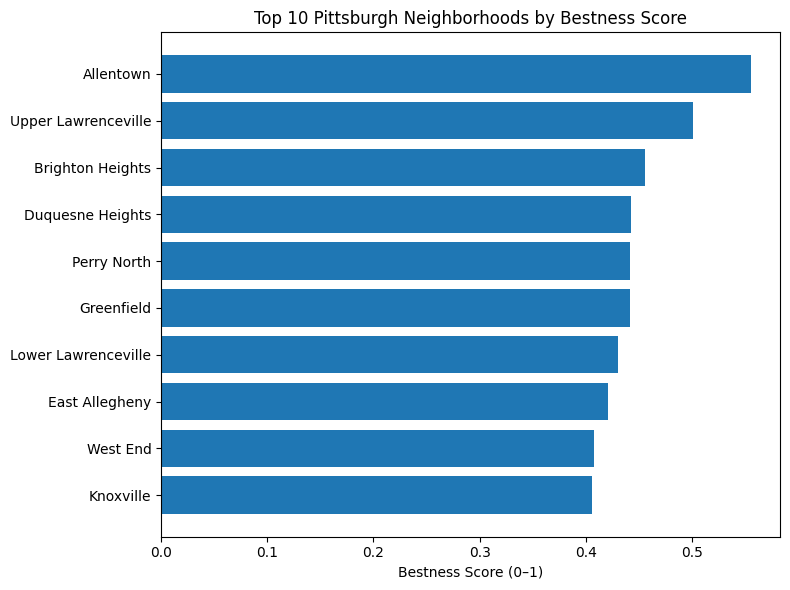

In [11]:
# Prepare data for plotting: sort ascending for a nicer horizontal bar chart
top10_plot = top10.sort_values("best_score", ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(top10_plot["hood"], top10_plot["best_score"])
plt.xlabel("Bestness Score (0–1)")
plt.title("Top 10 Pittsburgh Neighborhoods by Bestness Score")
plt.tight_layout()
plt.show()

In [12]:
# Optional: compare the three sub-metrics for the same top 10 neighborhoods
top10_metrics = top10[["hood", "trash_score", "parking_score", "steps_score"]].set_index("hood")

top10_metrics

,trash_score,parking_score,steps_score
hood,,,
Allentown,0.169825,0.844700,0.499831
Upper Lawrenceville,0.208132,1.000000,0.141001
Brighton Heights,0.120410,1.000000,0.074648
Duquesne Heights,0.027137,0.867257,0.253378
Perry North,0.069479,0.867257,0.221853
Greenfield,0.101311,0.760086,0.321573
Lower Lawrenceville,0.378007,0.590160,0.285086
East Allegheny,0.620263,0.627342,0.041457
West End,0.259233,0.734513,0.140391


## 6. Mapping Bestness across Pittsburgh

To show the spatial pattern of our metric, we join the Bestness scores with the official
Pittsburgh neighborhood boundaries shapefile and draw a choropleth map.

We use:

- `Neighborhoods_.shp` located in `data/raw/`
- The `hood` column in the shapefile, which matches the neighborhood names in our tables

Columns in shapefile: ['OBJECTID', 'fid_blockg', 'statefp10', 'countyfp10', 'tractce10', 'blkgrpce10', 'geoid10', 'namelsad10', 'mtfcc10', 'funcstat10', 'aland10', 'awater10', 'intptlat10', 'intptlon10', 'shape_leng', 'fid_neighb', 'perimeter', 'neighbor_', 'neighbor_i', 'hood', 'hood_no', 'acres', 'sqmiles', 'dpwdiv', 'unique_id', 'sectors', 'shape_le_1', 'shape_ar_1', 'page_numbe', 'plannerass', 'created_us', 'created_da', 'last_edite', 'last_edi_1', 'temp', 'pghdb_sde_', 'GlobalID', 'Shape__Are', 'Shape__Len', 'geometry']


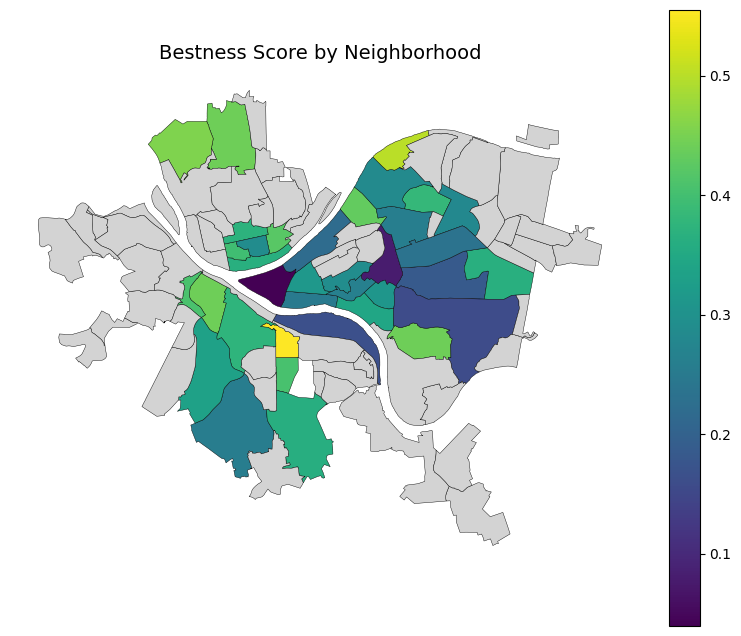

In [14]:
if GEOPANDAS_AVAILABLE:
    # Load neighborhood boundaries (ignore geometry when merging if desired)
    neighborhoods_shp = "../data/raw/Neighborhoods_.shp"
    neigh_gdf = gpd.read_file(neighborhoods_shp)

    print("Columns in shapefile:", list(neigh_gdf.columns))

    # We expect the attribute table to contain 'hood' (name) and geometry
    if "hood" not in neigh_gdf.columns:
        raise ValueError("Shapefile does not contain a 'hood' column. Please adjust the merge key.")

    # Merge spatial data with best score
    neigh_best = neigh_gdf.merge(
        best_df_clean[["hood", "best_score"]],
        on="hood",
        how="left"
    )

    # Plot choropleth
    ax = neigh_best.plot(
        column="best_score",
        legend=True,
        figsize=(10, 8),
        edgecolor="black",
        linewidth=0.3,
        missing_kwds={
            "color": "lightgrey",
            "label": "No data"
        }
    )
    ax.set_axis_off()
    ax.set_title("Bestness Score by Neighborhood", fontsize=14)
else:
    print("GeoPandas is not available – skipping the map.")